# 1 Actividad: Redes Neuronales Profundas
Alfonso Pineda Cedillo | A01660394

Mariana Ivette Rincón Flores | A01654973

Salvador Mendoza Tinoco | A01067783

Karla González Sánchez | A01541526

**Fecha de entrega:** 16 de Octubre de 2023

---

## 1.1 Instrucciones
Crear un dataset personalizado, donde incluyas 3 clasificaciones (Mouse, Telcado, Monitor)

Obtén el modelo de una red neuronal pre-entrenada e importalo en Google Colab, deberás asegurarte que sea una red que te sirva para la tarea en específico, (No usar Mobilenet)

Agregar una capa de clasificación y entrenarla. Deberás mostrar la gráfica de la precisión durante las épocas.

Realiza un ajuste fino y muestra la gráfica de la precisión, en donde se observe el historial de la etapa anterior.

Muestra un conjunto de predicciones.

Deberás subir un pdf que contenga todo el código y resultados. Además de tener ordenado el código completo.

## 1.2 Solución
Importamos las librerías necesarias para la actividad y realizamos la conexión correspondiente con nuestro Google Drive local.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow  as tf
from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.2.1 Procesamiento de datos
En esta sección se realiza el procesamiento de los datos, en este caso, se realiza la carga de las imágenes de los tres tipos de objetos que se van a clasificar, se les asigna una etiqueta y se guardan en un arreglo.

El proyecto se basa en dos directorios principales: “train” y “test”. El directorio “train” contiene un conjunto de datos con imágenes que se utilizarán para entrenar el modelo, mientras que el directorio “test” contiene imágenes que se emplearán para evaluar el rendimiento del modelo.

Se define el tamaño de lote (BATCH_SIZE) y el tamaño de las imágenes (IMG_SIZE) para estandarizar el procesamiento. A continuación, se especifica la ruta (PATH) al directorio que contiene los datos de entrenamiento. La variable train_dir se crea a partir de esta ruta, y se utiliza para cargar el
conjunto de datos de entrenamiento. La función image_dataset_from_directory se utiliza para cargar imágenes desde nuestro directorio y crear un conjunto de datos.

Las clases de clasificación se obtienen a través del atributo class_names del conjunto de datos de entrenamiento. Esto es esencial para comprender las categorías a las que pertenecen las imágenes en el conjunto de datos.

Debido a que nuestro dataset solo contiene imágenes correspondientes al conjunto de entrenamiento y prueba, se debe dividir el conjunto de entrenamiento en dos partes: entrenamiento y validación. Esto se realiza mediante la variable num_validation_samples para determinar el número de elementos en el conjunto de datos de validación, y luego se utilizan los métodos take y skip para dividirlo en dos partes.

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (200,200)

PATH = '/content/drive/MyDrive/TeamAI/computerParts/'

train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    shuffle=True,
                                                                    batch_size=BATCH_SIZE,
                                                                    image_size=IMG_SIZE)

class_names = train_dataset.class_names

# Calcula el número de muestras en el dataset de entrenamiento
num_samples = len(train_dataset)

# Calcula el número de muestras para el conjunto de validación (el 20%)
num_validation_samples = int(0.2 * num_samples)

# Divide el dataset de entrenamiento en entrenamiento y validación
validation_dataset = train_dataset.take(num_validation_samples)
train_dataset = train_dataset.skip(num_validation_samples)


test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle = True,
                                                                 batch_size = BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 732 files belonging to 3 classes.
Found 93 files belonging to 3 classes.


Posteriormente, creamos un figure que nos permitirá visualizar las imágenes de nuestro dataset y comprobar que estén clasificadas correctamente.

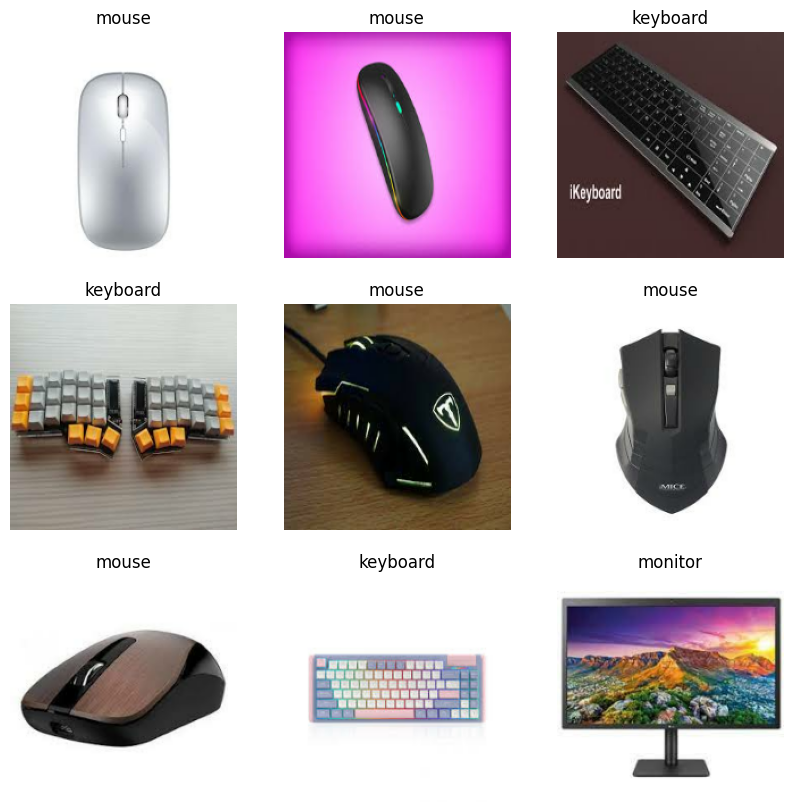

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

Posteriormente, calculamos el número de lotes en el conjunto de validación utilizando la función `tf.data.experimental.cardinality`. Esta información es importante para las divisiones posteriores.

Una vez que se ha calculado el número de lotes de validación, se procede a realizar divisiones adicionales en los conjuntos de datos de entrenamiento y validación. Estas divisiones se realizan utilizando la función `skip`. La cantidad de lotes que se omite se calcula como un valor fraccional del número total de lotes de validación.

Después de realizar las operaciones de preprocesamiento, se generan tres salidas que proporcionan información sobre el número de lotes disponibles en los conjuntos de datos resultantes.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches//5)
validation_dataset = validation_dataset.skip(val_batches//5)
train_dataset = train_dataset.skip(val_batches//5)

print('Number of validation batches for validation_dataset: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of validation batches for train_dataset: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches for test_dataset: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches for validation_dataset: 4
Number of validation batches for train_dataset: 19
Number of validation batches for test_dataset: 3


Utilizamos la variable `AUTOTUNE` para para determinar el tamaño del búfer de prefijación. `AUTOTUNE` es una constante especial que permite a TensorFlow ajustar automáticamente el tamaño del búfer según las capacidades del hardware y las necesidades del sistema.

Luego, el código aplica el método `prefetch` a tres conjuntos de datos diferentes: `train_dataset`,`validation_dataset` y `test_dataset`. Cuando se aplica `prefetch`, se especifica un `buffer_size`que determina la cantidad de datos que se preprocesan y almacenan en memoria antes de que el modelo los necesite. El valor `buffer_size` es igual a `AUTOTUNE`, lo que permite que TensorFlow ajuste automáticamente el tamaño del búfer para aprovechar al máximo la capacidad de procesamiento del sistema.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

Posteriormente, con ayuda de TensorFlow, realizamos un aumento de datos aplicando transformaciones aleatorias a las imágenes de nuestro dataset. Esto nos permite aumentar el tamaño de nuestro dataset y mejorar el rendimiento de nuestro modelo.

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2)
])

Realizamos la visualización de las transformaciones aplicadas a las imágenes de nuestro dataset.

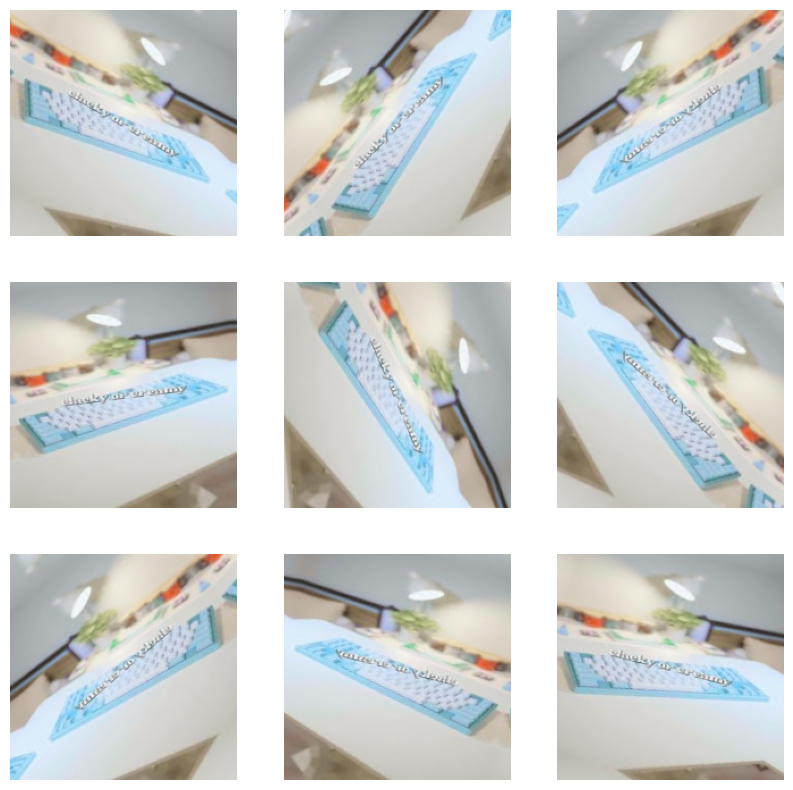

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image,0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis("off")

La reescalación es una técnica común en el preprocesamiento de imágenes que ajusta el rango de valores de píxeles de las imágenes. El siguiente código se utiliza la capa Rescaling de TensorFlow para llevar a cabo esta operación.

In [ ]:
recale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### 1.2.2 Cargar red pre entrenada
Definimos una variable `IMG_SHAPE` que representa las dimensiones de las imágenes que se utilizarán para entrenar el modelo. Estas dimensiones incluyen el ancho y el alto de las imágenes, junto con el número de canales de color (en este caso, 3 para imágenes `RGB`).

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)

base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

(200, 200, 3)


A continuación, utilizamos la arquitectura de red ResNet-50 a través de la biblioteca TensorFlow.Configuramos el modelo base utilizando la función `tf.keras.applications.ResNet50`.

Después de configurar el modelo base, tomamos un lote de imágenes y etiquetas del conjunto de entrenamiento. Utilizamos el método `next(iter(train_dataset))` para obtener estos lotes. Luego, aplicamos el modelo base a las imágenes para extraer características.

La variable feature_batch contendrá las características extraídas de las imágenes de entrada, lo
que es útil para tareas posteriores, como el entrenamiento de un clasificador personalizado.

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

print(feature_batch.shape)

(32, 7, 7, 2048)


Una consideración importante en la configuración del modelo es la capacidad de congelar (freeze) las capas entrenables del modelo base. En este caso, hemos establecido la propiedad trainable en False para todas las capas del modelo base. Esto significa que las capas pre-entrenadas no se actualizarán durante el entrenamiento subsiguiente, lo que es útil para conservar las representaciones previamente aprendidas

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_19[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

Configuramos una capa de “promedio global” utilizando la clase
`tf.keras.layers.GlobalAveragePooling2D()`. Esta capa es crucial en el proceso de reducción de dimensionalidad. Su función es calcular el promedio de todas las características en el tensor de características `feature_batch` para cada ejemplo. En otras palabras, realiza un promedio de todas las características en cada mapa de características, lo que da como resultado una salida con una sola característica por canal de características.

El resultado de esta operación es un tensor llamado `feature_batch_average` que contiene una representación promedio de las características para cada ejemplo en el lote de entrada. La forma de este tensor es de vital importancia, ya que nos proporciona información sobre la dimensionalidad de las características finales.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


Después de obtener el tensor `feature_batch_average`, lo pasamos a través de una capa completamente conectada (densa) utilizando `tf.keras.layers.Dense(3)`. Esta capa se utiliza para generar las predicciones finales del modelo. En este caso, hemos configurado la capa para tener 3 unidades de salida, debido a que nuestro conjunto de datos contiene tres clases de clasificación.

In [ ]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


### 1.2.3  Unimos la red pre-entrenada con nuestra red
Hemos comenzado configurando las capas de entrada del modelo utilizando `tf.keras.Input`. Las dimensiones de las imágenes de entrada se han establecido en 200x200 píxeles con 3 canales de color (RGB). Esto asegura que el modelo pueda manejar imágenes con las dimensiones adecuadas.

A continuación, hemos aplicado una serie de transformaciones de datos a las imágenes de entrada. Estas transformaciones incluyen `data_augmentation` y `preprocess_input`. La capa data_augmentation aplica transformaciones aleatorias a las imágenes, como el volteo horizontal y la rotación, para introducir variabilidad en los datos y ayudar al modelo a generalizar mejor.
La capa `preprocess_input` normaliza las imágenes de entrada de acuerdo con las especificaciones de la red neuronal pre-entrenada.

Posteriormente, hemos incorporado un modelo base pre-entrenado en la arquitectura ResNet-50 en nuestro modelo. Este modelo base se utiliza para extraer características significativas de las imágenes de entrada. Al establecer `training = False`, aseguramos que las capas del modelo base no se actualicen durante el proceso de entrenamiento. Esto es beneficioso para mantener las representaciones previamente aprendidas.

Para reducir la dimensionalidad de las características extraídas, hemos aplicado una capa de promedio global `(global_average_layer)`. Luego, hemos incorporado una capa de dropout con una tasa del 20% para regularizar el modelo y reducir el riesgo de sobreajuste.

Finalmente, hemos configurado una capa de salida `(outputs)` que genera las predicciones del modelo. En nuestro caso, estamos abordando un problema de clasificación en el que las clases son de naturaleza discreta. Hemos utilizado una función de pérdida `SparseCategoricalCrossentropy` y el optimizador Adam con una tasa de aprendizaje base de 0.0001.

In [ ]:
inputs = tf.keras.Input(shape=(200, 200, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 sequential_12 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 tf.math.truediv_6 (TFOpLam  (None, 200, 200, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_6 (TFOpLa  (None, 200, 200, 3)       0         
 mbda)                                                           
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0   

Hemos comenzado el proceso de entrenamiento con un número fijo de épocas iniciales, que en este caso se ha configurado en 10. La función `model.evaluate` calcula la pérdida y la precisión del modelo en los datos de validación y las almacena en las variables `loss0` y `accuracy0`. Esto nos
proporciona una métrica inicial de rendimiento antes de comenzar el entrenamiento.

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print(loss0)
print(accuracy0)

4/4 [==============================] - 4s 110ms/step - loss: 1.8215 - accuracy: 0.0703
1.8215330839157104
0.0703125


Después de la evaluación inicial, hemos procedido con el entrenamiento real del modelo utilizando el conjunto de datos de entrenamiento `(train_dataset)`. Hemos entrenado el modelo durante el número de épocas especificado en initial_epochs. Durante el entrenamiento, el modelo ajusta sus pesos y aprende a hacer predicciones más precisas.

In [ ]:
history = model.fit(train_dataset,
                    epochs = initial_epochs,
                    validation_data = validation_dataset)

Epoch 1/10
19/19 [==============================] - 7s 145ms/step - loss: 1.5252 - accuracy: 0.1457 - val_loss: 1.2115 - val_accuracy: 0.2422
Epoch 2/10
19/19 [==============================] - 3s 146ms/step - loss: 1.1710 - accuracy: 0.3377 - val_loss: 0.9960 - val_accuracy: 0.5625
Epoch 3/10
19/19 [==============================] - 4s 174ms/step - loss: 1.0046 - accuracy: 0.4636 - val_loss: 0.9255 - val_accuracy: 0.5234
Epoch 4/10
19/19 [==============================] - 3s 148ms/step - loss: 0.9355 - accuracy: 0.5497 - val_loss: 0.9069 - val_accuracy: 0.5234
Epoch 5/10
19/19 [==============================] - 3s 144ms/step - loss: 0.9160 - accuracy: 0.5447 - val_loss: 0.8922 - val_accuracy: 0.5625
Epoch 6/10
19/19 [==============================] - 4s 173ms/step - loss: 0.8707 - accuracy: 0.6060 - val_loss: 0.9134 - val_accuracy: 0.5703
Epoch 7/10
19/19 [==============================] - 3s 146ms/step - loss: 0.8516 - accuracy: 0.6043 - val_loss: 0.8774 - val_accuracy: 0.6484
Epoch 

Para evaluar el progreso del entrenamiento, hemos registrado las métricas de precisión en el conjunto de entrenamiento y el conjunto de validación después de cada época. Estas métricas se almacenan en las listas `acc` (precisión de entrenamiento) y `val_acc` (precisión de validación) a medida que avanzamos a través de las épocas.

Finalmente, hemos utilizado la biblioteca Matplotlib para crear un gráfico que muestra la precisión de entrenamiento y validación a lo largo de las épocas. En el gráfico, la precisión de entrenamiento se representa en verde claro y la precisión de validación en verde oscuro. Esta visualización nos
permite analizar cómo se comporta el modelo a medida que se entrena y si está sujeto a sobreajuste (overfitting) o subajuste (underfitting).

Text(0.5, 1.0, 'Training and Validation Accuracy')

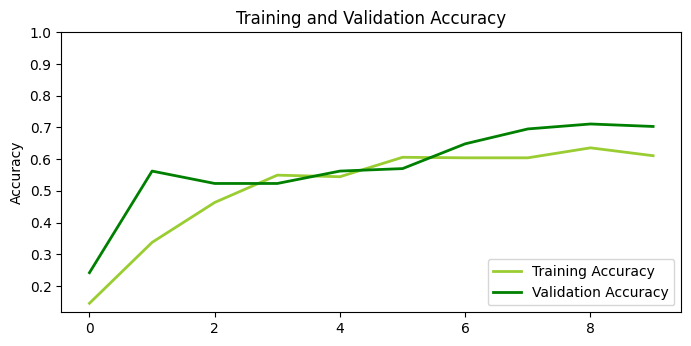

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='yellowgreen', linewidth=2)
plt.plot(val_acc, label='Validation Accuracy', color='green', linewidth=2)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

### 1.2.4 Fine Tuning

Hemos comenzado el proceso de fine tuning desbloqueando o descongelando las capas del modelo base. Esto significa que permitimos que las capas del modelo base se actualicen durante el entrenamiento, lo que es fundamental para adaptar el modelo a nuestro problema específico.

Asimismo, hemos impreso el número de capas presentes en el modelo base para tener una idea de su arquitectura y complejidad. Esto nos permite comprender cuántas capas se beneficiarán del ajuste.

In [ ]:
base_model.trainable = True # Descongelamos la base
print('Number of layers in the base model: ', len(base_model.layers))

Number of layers in the base model:  175


A continuación, hemos seleccionado un punto de referencia específico en el modelo base al establecer la variable `fine_tune_at` en 120. Esto significa que congelaremos las primeras 120 capas del modelo base y solo permitiremos que las capas a partir de la capa 121 en adelante se actualicen durante el
entrenamiento.

In [ ]:
fine_tune_at = 120 # Congelamos las primeras 120 capas
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Se compila nuevamente el modelo y se imprime el resumen del mismo. Utilizamos la función de pérdida `SparseCategoricalCrossentropy` para problemas de clasificación, y el optimizador Adam con una tasa de aprendizaje reducida `(lr=base_learning_rate/10)`. Esta reducción de la tasa de aprendizaje es una estrategia común durante el fine tuning, ya que evita cambios drásticos en las
representaciones previamente aprendidas.

In [ ]:
# Compilamos nuevamente el modelo

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10), metrics=['accuracy'])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 sequential_12 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 tf.math.truediv_6 (TFOpLam  (None, 200, 200, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_6 (TFOpLa  (None, 200, 200, 3)       0         
 mbda)                                                           
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0   

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 10/20
19/19 [==============================] - 20s 259ms/step - loss: 10.0831 - accuracy: 0.4305 - val_loss: 0.9581 - val_accuracy: 0.5156
Epoch 11/20
19/19 [==============================] - 5s 220ms/step - loss: 0.9341 - accuracy: 0.4768 - val_loss: 0.9663 - val_accuracy: 0.4375
Epoch 12/20
19/19 [==============================] - 5s 207ms/step - loss: 0.8855 - accuracy: 0.5861 - val_loss: 0.7032 - val_accuracy: 0.7734
Epoch 13/20
19/19 [==============================] - 4s 200ms/step - loss: 1.0936 - accuracy: 0.5662 - val_loss: 0.9147 - val_accuracy: 0.5547
Epoch 14/20
19/19 [==============================] - 5s 211ms/step - loss: 0.8122 - accuracy: 0.6258 - val_loss: 0.8859 - val_accuracy: 0.5625
Epoch 15/20
19/19 [==============================] - 5s 201ms/step - loss: 0.7016 - accuracy: 0.7119 - val_loss: 0.5485 - val_accuracy: 0.8047
Epoch 16/20
19/19 [==============================] - 4s 199ms/step - loss: 0.5352 - accuracy: 0.7897 - val_loss: 1.0621 - val_accuracy: 0.59

Durante el proceso de entrenamiento, hemos registrado las métricas de precisión en el conjunto de entrenamiento y el conjunto de validación en cada época. Las métricas se almacenan en las listas `acc` (precisión de entrenamiento) y `val_acc` (precisión de validación) a medida que avanzamos a
través de las épocas. Esto nos permite evaluar el rendimiento del modelo en ambos conjuntos de datos a lo largo del proceso de fine tuning.

Para visualizar el rendimiento del modelo durante el entrenamiento y el fine tuning, hemos creado un gráfico que muestra la precisión de entrenamiento y validación a lo largo de las épocas. En el gráfico, la precisión de entrenamiento se representa en verde claro y la precisión de validación en
verde oscuro. También hemos marcado el punto en el que comenzó el fine tuning con una línea roja punteada.

Text(0.5, 1.0, 'Training and Validation Accuracy')

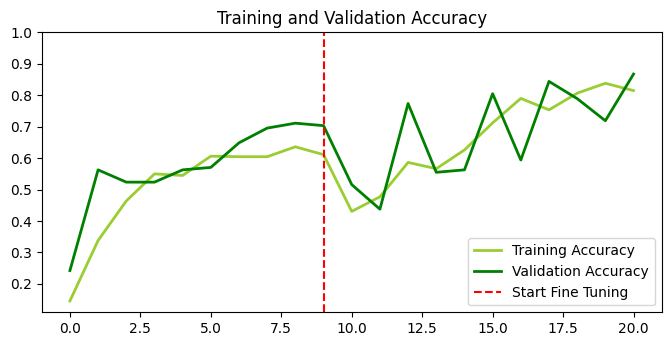

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='yellowgreen', linewidth=2)
plt.plot(val_acc, label='Validation Accuracy', color='green', linewidth=2)
plt.ylim([min(plt.ylim()), 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning', color = 'red', linestyle='--')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

### 1.2.5 Observación de resultados
Por último, realizamos una predicción con nuestro modelo y mostramos el resultado.


1/1 [==============================] - 0s 34ms/step


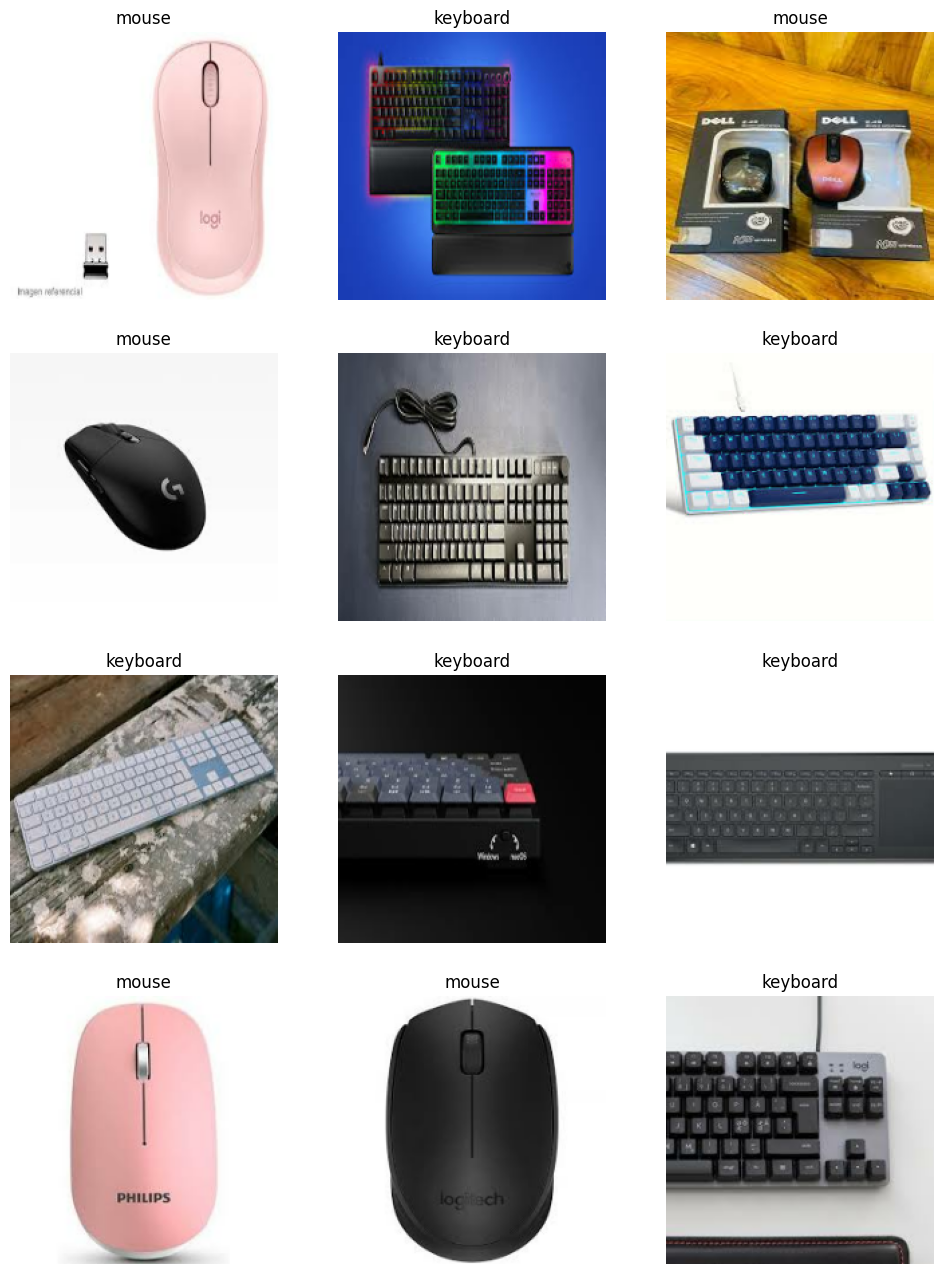

In [ ]:
# Obtén 12 ejemplos del conjunto de validación
validation_images, validation_labels = next(iter(validation_dataset.take(12)))

# Realiza predicciones con el modelo
predictions = model.predict(validation_images)

# Convierte las etiquetas de las predicciones en nombres de clases (si están codificadas en one-hot)

# Crea un figure con 3 columnas y 4 filas
fig, axes = plt.subplots(4, 3, figsize=(12, 16))

for i in range(12):
    ax = axes[i // 3, i % 3]
    ax.imshow(validation_images[i].numpy().astype('uint8'))
    ax.set_title(class_names[predictions[i].argmax()])
    ax.axis('off')

plt.show()